## NLP for Movie Plots
# Does director nationality (native-born vs. foreign-born) predict film box office performance?

*Hongyuan Jin, Eunseo Kang, Paige Harris, and Viki Papadakis*

## Purpose / Motivation

In addition to being one of the most lucrative industries in the world, the American film industry also has far-reaching societal impacts (Crane, 2014; Turner & Duckham, 2006). Not only do films provide a lens with which to document and view societal change (Stoddard & Marcus, 2010), but they also have the ability to catalyze change in their audience (e.g., changes in emotions, beliefs, and political behavior intentions; Butler et al., 1995). In considering both the economic and societal implications of American films, the importance of understanding what goes on “behind the scenes” of creating these films becomes clear.

One way to understand what may be going on “behind the scenes” of the American film industry is to examine the individuals with the most influence on films: the directors. Directors are responsible for various parts of the film-making process, and ultimately shape the film “vision” and outcome (Mackendrick & Cronin, 2005). As such, in order to better-understand the American film industry, we can examine the directors of American films. When looking at IMDB’s list of top contemporary film directors, however, one might notice that a significant proportion of these directors, who directly contribute to and shape the American film industry, are not native-born Americans.

The influence of culture is one that is both far-reaching and unavoidable. Whether an individual is born in the United States, Mexico, or South Korea (among other cultures), cultural norms from one’s country of origin permeate the psyche, even among immigrants who have acculturated to a new cultural environment (Markus & Kitayama, 2010). Because there is cultural diversity (i.e., different countries of origin) among prominent American film directors, there is reason to believe that the outcome of these films may differ as a function of whether a film director is native- vs. foreign-born. As of yet, no study has systematically examined the role of film director immigrant status (i.e., native- vs. foreign-born) on movie outcome.

In the present data science project, we will examine the effect of director immigrant status (i.e., native- vs. foreign-born) on film contribution. Box office revenue is a useful way for understanding both the economic and societal contribution of a film, as it provides information on fiscal gains, as well as the reach and popularity of the film. As such, in the present data science project, we will examine the effect of director immigrant status (i.e., native- vs. foreign-born) on box office revenue (both domestic and international) for American films.

## Methodology
Movies with similar plots are commonplace (e.g., twin films, mockbuster films). As a first step, then, it is important that we cluster among movies with similar plots. Clustering refers to a systematic grouping of data based on some pattern -- in our case, we are interested in clustering similar movies together based on their plot summaries. Clustering provides many benefits from a data scientific perspective, and aids in data organization, interpretation, and detection of anomalies (Jain, Murty, & Flynn, 1999).

We utilized natural language processing (NLP) tools in order to cluster similar movies together based on movie plot summaries. Essentially, NLP allows for computers to recognize and make sense of language (Roldós, 2020). NLP is faster, more accurate, and more efficient compared to human coders. Because we have a big dataset with lots of movies (over 4,600  movies) and each movie plot summary contains lots of text (average movie plot had nearly 3,200 tokens), we employed NLP to better understand the summaries.

- TF-IDF
- LDA

These allowed us to group movies based on similar plots so that when we examined how our primary predictor is associated with our outcomes, we could do so within-cluster. This way, we could look among similar movies and see how director nationality is related to movie success. Essentially, we could compare apples to apples and oranges to oranges.

After conducting our LDA, we noticed that a lot of the tokens that emerged were the names of characters in the movies. We did not want our movies to be grouped by names; ideally, the movies would be placed into groups by how similar the plots were. So, we addressed this issue by replacing the names with “character.” This way, the names would not be as relevant.
After addressing this issue, we ran the NLP analyses again. So, we conducted the TF-IDF and LDA analyses twice.
Below is a breakdown:

- Original Movie Plot Summaries (before replacing names with “character”)
    - TF-IDF → used cosine similarity and formed 23 clusters
    - LDA → used top major topics and formed 23 clusters
- Updated Movie Plot Summaries (after replacing names with “character”)
    - TF-IDF → used cosine similarity and formed 23 clusters
    - LDA → used top major topics and formed 23 clusters

To test the validity of the clusterings based on the movie plots, we conducted chi-squared test with the original
movie Genre categorization. We found based on the test that all four sets of clusterings return stable and
 sensible clustering results in a sense that the movies with similar plots tend to fall onto the same genre
 category as well.

To see if the results were comparable across the different clustering methods, we used these 4 sets of 23 clusters in the the different regression analyses.


## Results
- TF-IDF and LDA worked consistently with plot analysis and clustering.
- The American movie industry has important economic and societal impacts, and it appears that director country of origin affects these movies’ contributions.
- Domestic directors have an advantage in the domestic movie market.
- Foreign-born yields higher box office outcomes in the international movie market compared to their domestic counterparts when every other factor is the same.

## Suggested next steps
- Examine how director roles impact movie success
- Investigate how other crew members (e.g., producer, cinematographer) predict box office sales
- Further investigate within the clusters - whether the release year (order) affects box office performance


# Setup

## Library import for Python
We import all the required Python libraries

In [663]:
import os
# print("Current Working Directory " , os.getcwd())

from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

import matplotlib as plt
import matplotlib.pyplot as pplt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
import re
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

## Library import for R
We enable R in the notebook and import all the required libraries.

In [664]:
%load_ext rpy2.ipython
;

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


''

In [665]:
%%R
# install.packages("ggplot2", repos='http://cran.us.r-project.org', quiet=TRUE)
library(ggplot2)
library(fixest)
library(dplyr)
library(tidyr)
library(tidyverse)
# install.packages("lmtest")
library(lmtest)
library(sandwich);

## Local library import
We import all the required local libraries

In [666]:
# Include local library paths
import sys
# sys.path.append('path/to/local/lib') # uncomment and fill to import local libraries

# Import local libraries

# Data import
- Movie plots (*movies_df*)
    - source:

- Other movie attributes (*movie_other*)
    - source:

- Top star list data (*topstar*)
    - source:

We first retrieve the data for the movie summary plots.

In [667]:
folder = Path("~/Dropbox/Course/PSTAT234/spr21/pstat234-final-project")
# Change the path do your own directory

movies_df = pd.read_csv(folder/'wiki_movie_plots_deduped.csv')
movies_df.head(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


## Data for Movie Plots
We retrieve the data for the movies that were:
- Produced in the US
- Released between 1990 and 2010

This returns the set of 4631 movies in total.

In [668]:
# movies_df_sub = movies_df[(movies_df['Origin/Ethnicity']=="American")].reset_index(drop=True)
movies_df_sub = movies_df[(movies_df['Release Year']>=1990) &
                          (movies_df['Release Year']<=2010) &
                          (movies_df['Origin/Ethnicity']=="American")].\
    reset_index(drop=True)
# movies_df_sub = movies_df[(movies_df['Release Year']==2005) &
                          # (movies_df['Origin/Ethnicity']=="American")].\
    # reset_index(drop=True)
movies_df_sub = movies_df_sub.drop(['Origin/Ethnicity', 'Wiki Page'], axis = 1)
movies_df_sub.head(5)
# 4631 movies to analyze

,Release Year,Title,Director,Cast,Genre,Plot
0,1990,The Adventures of Ford Fairlane,Renny Harlin,"Andrew Dice Clay, Wayne Newton, Priscilla Pres...",comedy,Ford Fairlane (Andrew Dice Clay) is seen sitti...
1,1990,"After Dark, My Sweet",James Foley,"Jason Patric, Rachel Ward, Bruce Dern",mystery,"Ex-boxer Kevin ""Kid"" Collins is a drifter and ..."
2,1990,Air America,Roger Spottiswoode,"Mel Gibson, Robert Downey, Jr., Nancy Travis",comedy,"In late 1969, Billy Covington (Robert Downey J..."
3,1990,Alice,Woody Allen,"Mia Farrow, Joe Mantegna, William Hurt, Alec B...",comedy,Alice Tate is an upper-class New York housewif...
4,1990,Almost an Angel,John Cornell,"Paul Hogan, Elias Koteas, Charlton Heston",comedy,"Terry Dean (Paul Hogan), a professional burgla..."


In [669]:
movies_df_sub['Plot'].apply(len).describe()

count     4631.000000
mean      3194.705031
std       1759.174164
min         35.000000
25%       1916.500000
50%       3430.000000
75%       4205.000000
max      25123.000000
Name: Plot, dtype: float64

The above says that each plot contains on average 3195 tokens.

# Data Processing for Movie Plots

## NLP
- TF-IDF
- LDA

Eventually, we want to cluster the movies with similar plots based on the NLP analysis.

### TF-IDF

In [670]:
stemmer = SnowballStemmer("english", ignore_stopwords=False)

def normalize(X):
    normalized = []
    totalvocab_tokenized = []
    for x in X:
        words = nltk.word_tokenize(x)
        normalized.append(' '.join([stemmer.stem(word) for word in words if re.match('[a-zA-Z]+', word)]))
        totalvocab_tokenized.extend(words)
    return normalized

pipe = Pipeline([
    ('normalize', FunctionTransformer(normalize, validate=False)),
    ('counter_vectorizer', CountVectorizer(
        max_df=0.8, max_features=200000,
        min_df=0.2, stop_words='english',
        ngram_range=(1, 3)
    )),
    ('tfidf_transform', TfidfTransformer())
])

In [671]:
# Applying to the movie plots

tfidf_matrix = pipe.fit_transform([x for x in movies_df_sub['Plot']])
print(tfidf_matrix.shape)
# print(tfidf_matrix)

(4631, 118)


In [672]:
# Evaluate the similarity among the movies from the plot word frequency
similarity_distance = 1 - cosine_similarity(tfidf_matrix)
# similarity_distance

We test for finding similar movies for a given title

In [673]:
# this returns the top 10 most similar movies for a given movie title
# based on the cosine similarity

def find_similar(title):
    index = movies_df_sub[movies_df_sub['Title'] == title].index[0]
    vector = similarity_distance[index, :]
    most_similar = movies_df_sub.iloc[np.argsort(vector)[0:10], 0:2]
    return most_similar

### Example
The movies similar to *Madagascar (2005)* according to TF-IDF.

In [674]:
print(find_similar('Madagascar'))

      Release Year                           Title
3374          2005                      Madagascar
1194          1995      The Pebble and the Penguin
3607          2006                      Happy Feet
1775          1997                 Robinson Crusoe
2602          2001                Saving Silverman
3094          2004     Clifford's Really Big Movie
4497          2010                          Frozen
1269          1996  Alien Nation: The Enemy Within
1955          1998                      The Mighty
1306          1996           Cannibal! The Musical


### Movie clustering based on TF-IDF

- Kmeans clustering
- 23 clusters, in comparison to the number of Genres
- create an attribute *cluster_tfidf_first* for the cluster labeling in the dataframe

In [675]:
from sklearn.cluster import KMeans

# num_clusters = len(np.unique(movies_df_sub['Genre']))
num_clusters = 23
# print(num_clusters)
km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

import joblib

joblib.dump(km, 'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
cluster_tfidf_first = km.labels_.tolist()

In [676]:
templist = {'title': movies_df_sub["Title"], 'Release_year':  movies_df_sub["Release Year"],
            'Plot':  movies_df_sub['Plot'], 'cluster_tfidf_first': cluster_tfidf_first,
            'Director':  movies_df_sub['Director'], 'Genre':  movies_df_sub['Genre']}
frame = pd.DataFrame(data=templist)
# frame.head(2)
# print(frame['cluster_tfidf_first'].value_counts())

### Visualize the Clusters

/Users/aj/PycharmProjects/film_python/jupyter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



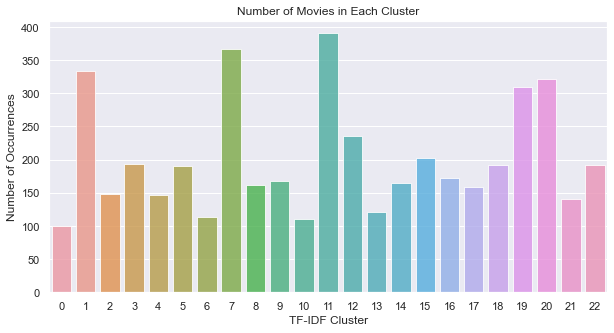

In [677]:
clus_count = frame['cluster_tfidf_first'].value_counts()
pplt.figure(figsize=(10,5))
sns.barplot(clus_count.index, clus_count.values, alpha=0.8)
pplt.title('Number of Movies in Each Cluster')
pplt.ylabel('Number of Occurrences', fontsize=12)
pplt.xlabel('TF-IDF Cluster', fontsize=12)
pplt.show()

Word Cloud for all the movies

In [678]:
from nltk.corpus import stopwords
plots = []
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
for words in movies_df_sub.Plot:
    only_letters = re.sub("[^a-zA-Z]", " ", words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizes the words i.e convert similar words to their
    # base form while still considering the context in which the words are used
    plots.append(' '.join(lemmas))

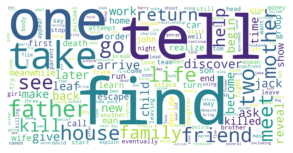

In [679]:
unique_string=(" ").join(plots)
wordcloud = WordCloud(width = 2000, height = 1000, background_color='white').generate(unique_string)
plt.pyplot.imshow(wordcloud, interpolation='bilinear')
plt.pyplot.axis("off")
plt.pyplot.show()

We show the first four movies in each cluster for first four clusters.

In [680]:
frame_select = frame[['title', 'cluster_tfidf_first', 'Genre', 'Release_year']]
frame_select.sort_values(['cluster_tfidf_first']).groupby('cluster_tfidf_first').head(4)[:16]

,title,cluster_tfidf_first,Genre,Release_year
1380,The Great White Hype,0,comedy,1996
4153,Never Back Down,0,action,2008
887,Kickboxer 4,0,unknown,1994
2736,I Spy,0,action,2002
2678,Buying the Cow,1,comedy,2002
351,Other People's Money,1,"drama, comedy",1991
838,Disclosure,1,thriller,1994
4537,Leap Year,1,romantic comedy,2010
3341,House of D,2,comedy,2005
1585,Best Men,2,comedy,1997


#### Word cloud for each cluster

We show the top words in randomly picked two clusters below.

In [681]:
# temp = frame.groupby('cluster_tfidf_first').sample(4)
#
# cv=CountVectorizer(max_df=0.85,stop_words=stop_words,max_features=10000)
#
# # keywords_cluster = []
# # for i in frame.cluster_tfidf_first.to_list():
# #     word_count_vector[i]=cv.fit_transform([x for x in temp['Plot']])
# #     keywords_cluster.append(list(cv.vocabulary_.keys())[:10])


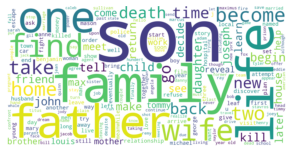

In [682]:
tempframe = frame[['title', 'cluster_tfidf_first', 'Plot']]
tempframe_sub = tempframe[tempframe['cluster_tfidf_first']==2].reset_index(drop=True)

from nltk.corpus import stopwords
plots = []
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
for words in tempframe_sub.Plot:
    only_letters = re.sub("[^a-zA-Z]", " ", words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizes the words i.e convert similar words to their
    # base form while still considering the context in which the words are used
    plots.append(' '.join(lemmas))

unique_string=(" ").join(plots)
wordcloud = WordCloud(width = 2000, height = 1000, background_color='white').generate(unique_string)
plt.pyplot.imshow(wordcloud, interpolation='bilinear')
plt.pyplot.axis("off")
plt.pyplot.show()

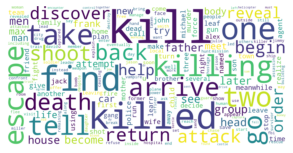

In [683]:
tempframe = frame[['title', 'cluster_tfidf_first', 'Plot']]
tempframe_sub = tempframe[tempframe['cluster_tfidf_first']==11].reset_index(drop=True)

from nltk.corpus import stopwords
plots = []
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
for words in tempframe_sub.Plot:
    only_letters = re.sub("[^a-zA-Z]", " ", words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizes the words i.e convert similar words to their
    # base form while still considering the context in which the words are used
    plots.append(' '.join(lemmas))

unique_string=(" ").join(plots)
wordcloud = WordCloud(width = 2000, height = 1000, background_color='white').generate(unique_string)
plt.pyplot.imshow(wordcloud, interpolation='bilinear')
plt.pyplot.axis("off")
plt.pyplot.show()

## LDA
Using this method, we took a closer look at the tokens from each plot summary, which represent a broader, latent topic, or theme. Essentially, similar topics appeared across the plot summaries, so we clustered the movies (again, with 23 clusters) based on the similar topics that emerged. LDA allowed us to determine which topics represent each cluster (Ganegadera, 2018; Kulshrestha, 2019; Li, 2018). We examined these topics using word clouds (see below).

In [684]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

processed_docs = frame['Plot'].map(preprocess)
processed_docs[:10]

dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    # print(k, v)
    count += 1
    if count > 15:
        break

dictionary.filter_extremes(no_below=20, no_above=0.1, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=23, id2word=dictionary, passes=2, workers=3)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))


Topic: 0 Word: 0.005*"daniel" + 0.003*"tommi" + 0.003*"kevin" + 0.003*"michael" + 0.003*"paul" + 0.003*"jake" + 0.003*"edward" + 0.003*"mike" + 0.003*"sara" + 0.002*"dean"
Topic: 1 Word: 0.003*"mike" + 0.003*"tommi" + 0.002*"nick" + 0.002*"harri" + 0.002*"jimmi" + 0.002*"terri" + 0.002*"victor" + 0.002*"jack" + 0.002*"audrey" + 0.002*"kong"
Topic: 2 Word: 0.004*"kate" + 0.002*"charli" + 0.002*"elliot" + 0.002*"nick" + 0.002*"david" + 0.002*"frank" + 0.002*"island" + 0.002*"carter" + 0.002*"ryan" + 0.002*"jack"
Topic: 3 Word: 0.004*"simon" + 0.003*"alex" + 0.003*"charlott" + 0.003*"jess" + 0.003*"adam" + 0.003*"jack" + 0.002*"frank" + 0.002*"rocki" + 0.002*"clair" + 0.002*"martin"
Topic: 4 Word: 0.005*"marcus" + 0.003*"killer" + 0.002*"sarah" + 0.002*"campbel" + 0.002*"kyle" + 0.002*"edward" + 0.002*"frank" + 0.002*"angela" + 0.002*"andi" + 0.002*"jessica"
Topic: 5 Word: 0.003*"king" + 0.003*"jack" + 0.003*"frank" + 0.002*"grace" + 0.002*"samantha" + 0.002*"nichola" + 0.002*"kelli" + 0.

The above shows the distribution of topics by the tokens.
- the algorithm seems to pick up the distinction across the movie plots by the character names
- we cluser the movies based on this LDA result and further visualize the movies within the same cluster
- come up with an amendment for the issue in the next section

#### Cluster based on LDA

- Based on the major topic (by the highest probability)
- Fuzzy Kmeans (TBA)

In [685]:
lda_corpus = lda_model_tfidf[corpus_tfidf]
all_topics = lda_model_tfidf.get_document_topics(corpus_tfidf)

num_docs = len(all_topics)

all_topics_csr= gensim.matutils.corpus2csc(all_topics)
all_topics_numpy= all_topics_csr.T.toarray()

major_topic = [np.argmax(arr) for arr in all_topics_numpy]
frame['cluster_lda_major_first']= major_topic

/Users/aj/PycharmProjects/film_python/jupyter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



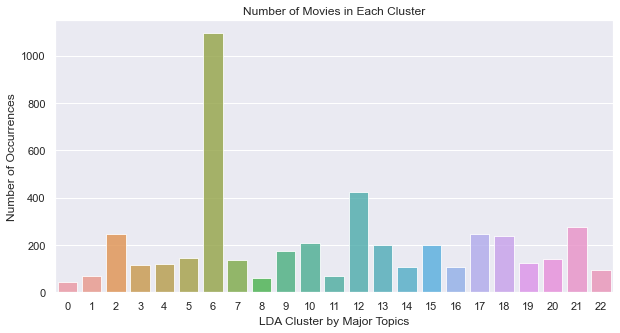

In [686]:
clus_count = frame['cluster_lda_major_first'].value_counts()
pplt.figure(figsize=(10,5))
sns.barplot(clus_count.index, clus_count.values, alpha=0.8)
pplt.title('Number of Movies in Each Cluster')
pplt.ylabel('Number of Occurrences', fontsize=12)
pplt.xlabel('LDA Cluster by Major Topics', fontsize=12)
pplt.show()

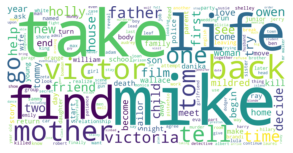

In [687]:
tempframe = frame[['title', 'cluster_lda_major_first', 'Plot']]
tempframe_sub = tempframe[tempframe['cluster_lda_major_first']==1].reset_index(drop=True)

from nltk.corpus import stopwords
plots = []
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
for words in tempframe_sub.Plot:
    only_letters = re.sub("[^a-zA-Z]", " ", words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizes the words i.e convert similar words to their
    # base form while still considering the context in which the words are used
    plots.append(' '.join(lemmas))

unique_string=(" ").join(plots)
wordcloud = WordCloud(width = 2000, height = 1000, background_color='white').generate(unique_string)
plt.pyplot.imshow(wordcloud, interpolation='bilinear')
plt.pyplot.axis("off")
plt.pyplot.show()

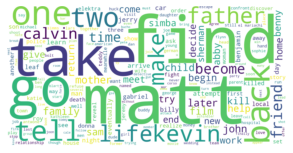

In [688]:
tempframe = frame[['title', 'cluster_lda_major_first', 'Plot']]
tempframe_sub = tempframe[tempframe['cluster_lda_major_first']==14].reset_index(drop=True)

from nltk.corpus import stopwords
plots = []
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
for words in tempframe_sub.Plot:
    only_letters = re.sub("[^a-zA-Z]", " ", words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizes the words i.e convert similar words to their
    # base form while still considering the context in which the words are used
    plots.append(' '.join(lemmas))

unique_string=(" ").join(plots)
wordcloud = WordCloud(width = 2000, height = 1000, background_color='white').generate(unique_string)
plt.pyplot.imshow(wordcloud, interpolation='bilinear')
plt.pyplot.axis("off")
plt.pyplot.show()

In [689]:
# Copyright Mathieu Blondel December 2011
# License: BSD 3 clause
# https://gist.github.com/mblondel/1451300
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans as KMeansGood
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from sklearn.datasets import make_blobs

##############################################################################
class KMeans(BaseEstimator):

    def __init__(self, k, max_iter=100, random_state=0, tol=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol

    def _e_step(self, X):
        self.labels_ = euclidean_distances(X, self.cluster_centers_,
                                           squared=True).argmin(axis=1)

    def _average(self, X):
        return X.mean(axis=0)

    def _m_step(self, X):
        X_center = None
        for center_id in range(self.k):
            center_mask = self.labels_ == center_id
            if not np.any(center_mask):
                # The centroid of empty clusters is set to the center of
                # everything
                if X_center is None:
                    X_center = self._average(X)
                self.cluster_centers_[center_id] = X_center
            else:
                self.cluster_centers_[center_id] = self._average(X[center_mask])

    def fit(self, X, y=None):
        n_samples = X.shape[0]
        vdata = np.mean(np.var(X, 0))

        random_state = check_random_state(self.random_state)
        self.labels_ = random_state.permutation(n_samples)[:self.k]
        self.cluster_centers_ = X[self.labels_]

        for i in range(self.max_iter):
            centers_old = self.cluster_centers_.copy()

            self._e_step(X)
            self._m_step(X)

            if np.sum((centers_old - self.cluster_centers_) ** 2) < self.tol * vdata:
                break

        return self

class KMedians(KMeans):

    def _e_step(self, X):
        self.labels_ = manhattan_distances(X, self.cluster_centers_).argmin(axis=1)

    def _average(self, X):
        return np.median(X, axis=0)

class FuzzyKMeans(KMeans):

    def __init__(self, k, m=2, max_iter=100, random_state=0, tol=1e-4):
        """
        m > 1: fuzzy-ness parameter
        The closer to m is to 1, the closter to hard kmeans.
        The bigger m, the fuzzier (converge to the global cluster).
        """
        self.k = k
        assert m > 1
        self.m = m
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol

    def _e_step(self, X):
        D = 1.0 / euclidean_distances(X, self.cluster_centers_, squared=True)
        D **= 1.0 / (self.m - 1)
        D /= np.sum(D, axis=1)[:, np.newaxis]
        # shape: n_samples x k
        self.fuzzy_labels_ = D
        self.labels_ = self.fuzzy_labels_.argmax(axis=1)

    def _m_step(self, X):
        weights = self.fuzzy_labels_ ** self.m
        # shape: n_clusters x n_features
        self.cluster_centers_ = np.dot(X.T, weights).T
        self.cluster_centers_ /= weights.sum(axis=0)[:, np.newaxis]

    def fit(self, X, y=None):
        n_samples, n_features = X.shape
        vdata = np.mean(np.var(X, 0))

        random_state = check_random_state(self.random_state)
        self.fuzzy_labels_ = random_state.rand(n_samples, self.k)
        self.fuzzy_labels_ /= self.fuzzy_labels_.sum(axis=1)[:, np.newaxis]
        self._m_step(X)

        for i in range(self.max_iter):
            centers_old = self.cluster_centers_.copy()

            self._e_step(X)
            self._m_step(X)

            if np.sum((centers_old - self.cluster_centers_) ** 2) < self.tol * vdata:
                break

        return self

In [690]:
# we applied the above fuzzyKmeans clustering to our LDA outcomes
# fuzzy_kmeans = FuzzyKMeans(k = 23, m = 1.5)
# the closer m is to 1, the closer the clustering is to hard clustering

# fuzzy_kmeans.fit(all_topics)

## Import data for names and replace the character names with string 'character'
After conducting our LDA, we noticed that a lot of the tokens that emerged were the names of characters in the movies. We did not want our movies to be grouped by names; ideally, the movies would be placed into groups by how similar the plots were. So, we addressed this issue by replacing the names with “character.” This way, the names would not be as relevant.

*Data source for names: Social Security https://www.ssa.gov/oact/babynames/limits.html*

In [691]:
# load names.zip which has more names data txt files
import zipfile
with zipfile.ZipFile('/Users/aj/Dropbox/Course/PSTAT234/spr21/pstat234-final-project/names.zip', 'r') as zip_ref:
    zip_ref.extractall('names/')

In [692]:
allnames_files = Path('names').glob('yob*')
# print(allnames_files)
# allnames_files.sort()
allnames_list = list()

for f in allnames_files:
    step_1 = pd.read_csv(f, delimiter = ',', header=None)
    allnames_list.append(step_1)
allnames = pd.concat(allnames_list)
allnames.columns = ["name", 'gender', 'count']
allnames.shape
# drop gender and aggregate the counts groupby names
allnames.drop(['gender'], axis = 1, inplace = True)

In [693]:
# allnames.dtypes
allnames['totalcount'] = allnames['count'].\
    groupby(allnames['name']).transform('sum')
allnames.drop('count', axis = 1, inplace=True)
allnames.head
allnames.describe()

,totalcount
count,2.020863e+06
mean,3.401396e+04
std,1.910011e+05
min,5.000000e+00
25%,2.540000e+02
50%,9.560000e+02
75%,5.048000e+03
max,5.213689e+06


In [694]:
# drop duplicates and keep only the names with count larger than 100
allnames.drop_duplicates(subset='name', inplace= True)
allnames = allnames.sort_values(by = ['totalcount'], ascending=False)
# allnames = allnames[allnames['totalcount']>=5000]
allnames.head()
# there are in total 100364 unique names in the dataset, we will use \
# top 2000 names by the totalcount

,name,totalcount
3359,James,5213689
4466,John,5163958
5114,Robert,4849738
1567,Michael,4405274
3521,William,4159868


### Replace the names in the plot with 'Character'

There are several shortfalls with this approach:
- Replacement took a long time to run
    - Looping over each movie plot with 1000 names took about 31 minutes.
- The updated plots still contain the names that were not within the top 1000 list.
- Last names were not replaced well

Reason: the time horizon is long, the words (excl. the names) that were used to
describe the plots appear to be less prominent than the character names.

Future amendment:
   - We can try run the analysis on movies fall on a shorter time window of
     the release years (eg. 5 years), where the distinction in the words
     for content may be more prominent than the names.


In [695]:
# %%time
# # DO NOT NEED TO RUN
# ALERT: THIS CELL TAKES EVEN LONGER TO RUN
# The name is a list from the all names data
# there are in total 100364 unique names in the dataset, we will use \
# top 1000 names by the totalcount
# new_movie_sub = movies_df[(movies_df['Release Year']>=1990) &
#                           (movies_df['Release Year']<=2010) &
#                           (movies_df['Origin/Ethnicity']=="American")].\
#     reset_index(drop=True)
#
# new_movie_sub = new_movie_sub.drop(['Origin/Ethnicity', 'Wiki Page'], axis = 1)
# name = allnames.name.to_list()
# for i in new_movie_sub.index:
#     for tag in name[:1000]:
#         new_movie_sub.Plot[i] = re.sub(r'\b' + tag + r'\b', 'Character', new_movie_sub.Plot[i])

In [696]:
# # save the new movie plot to data
# new_movie_sub.to_csv('replaced_character_movie_plots.csv', index=False)


## Load the data for updated plots

In [697]:
new_movies_df = pd.read_csv("replaced_character_movie_plots.csv")
new_movies_df.Plot[5]
new_movies_df.shape

(4631, 6)

### TF-IDF with the updated plot summaries

In [700]:
tfidf_matrix_new = pipe.fit_transform([x for x in new_movies_df['Plot']])
print(tfidf_matrix_new.shape)
from sklearn.cluster import KMeans
num_clusters = 23
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix_new)

joblib.dump(km, 'doc_cluster_new.pkl')

km = joblib.load('doc_cluster_new.pkl')
clusters = km.labels_.tolist()

(4631, 120)


In [701]:
# print(len(clusters))

In [702]:
frame['cluster_tfidf_second'] = clusters

In [703]:
films_select = frame[['title', 'cluster_tfidf_second', 'Genre', 'Release_year']]
films_select.sort_values(['cluster_tfidf_second']).groupby('cluster_tfidf_second').head(4)[:16]

,title,cluster_tfidf_second,Genre,Release_year
1604,Chinese Box,0,drama,1997
2915,Evil Alien Conquerors,0,"science fiction, comedy",2003
4372,Nine,0,musical,2009
372,Road to Ruin,0,comedy,1991
4286,Duplicity,1,crime,2009
1611,Cop Land,1,crime drama,1997
2298,The Crossing,1,historical drama,2000
1568,Amistad,1,drama,1997
3973,Persepolis,2,animation,2007
3403,"The Prize Winner of Defiance, Ohio",2,biography,2005


In [704]:
similarity_distance_new = 1 - cosine_similarity(tfidf_matrix_new)
# similarity_distance_new

def find_similar(title):
    index = frame[frame['title'] == title].index[0]
    vector = similarity_distance_new[index, :]
    most_similar = frame.iloc[np.argsort(vector)[0:10], 0:2]
    return most_similar

print(find_similar('Madagascar'))


                              title  Release_year
3374                     Madagascar          2005
1194     The Pebble and the Penguin          1995
3607                     Happy Feet          2006
1775                Robinson Crusoe          1997
4497                         Frozen          2010
1955                     The Mighty          1998
625           Cannibal! The Musical          1993
1306          Cannibal! The Musical          1996
2835                Treasure Planet          2002
4229  You Don't Mess with the Zohan          2008


Word Cloud for all the movies with the updated plots

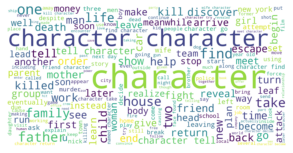

In [705]:
from nltk.corpus import stopwords
plots = []
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
for words in new_movies_df.Plot:
    only_letters = re.sub("[^a-zA-Z]", " ", words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizes the words i.e convert similar words to their
    # base form while still considering the context in which the words are used
    plots.append(' '.join(lemmas))

unique_string=(" ").join(plots)
wordcloud = WordCloud(width = 2000, height = 1000, background_color='white').generate(unique_string)
plt.pyplot.imshow(wordcloud, interpolation='bilinear')
plt.pyplot.axis("off")
plt.pyplot.show()

Word cloud with all movie plots for the most important words using countervectorizer

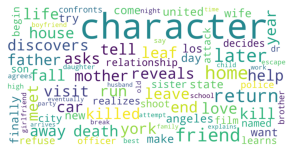

In [706]:
# the most important words in messages using countvectorizer
cv = CountVectorizer(analyzer = "word",stop_words = 'english', max_features = 100, ngram_range=(2,2))
important_words = cv.fit_transform(plots)
fig_words = cv.vocabulary_

#wordcloud for important words
unique_data=(" ").join(fig_words)
wordcloud = WordCloud(width = 2000, height = 1000, background_color="white").generate(unique_data)
plt.pyplot.imshow(wordcloud)
plt.pyplot.axis("off")
plt.pyplot.show()
plt.pyplot.close()

LDA with the updated plot summaries

In [ ]:
processed_docs = new_movies_df['Plot'].map(preprocess)
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    # print(k, v)
    count += 1
    if count > 15:
        break

dictionary.filter_extremes(no_below=20, no_above=0.1, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=23, id2word=dictionary, passes=2, workers=3)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

lda_model_tfidf_finer = gensim.models.LdaMulticore(corpus_tfidf, num_topics=46, id2word=dictionary, passes=2, workers=3)
# for idx, topic in lda_model_tfidf.print_topics(-1):
#     print('Topic: {} Word: {}'.format(idx, topic))

In [ ]:
lda_corpus = lda_model_tfidf[corpus_tfidf]
all_topics = lda_model_tfidf.get_document_topics(corpus_tfidf)

num_docs = len(all_topics)

all_topics_csr= gensim.matutils.corpus2csc(all_topics)
all_topics_numpy= all_topics_csr.T.toarray()

major_topic = [np.argmax(arr) for arr in all_topics_numpy]
frame['cluster_lda_major_second']= major_topic

all_topics_finer = lda_model_tfidf_finer.get_document_topics(corpus_tfidf)

num_docs_finer = len(all_topics_finer)

all_topics_csr_finer = gensim.matutils.corpus2csc(all_topics_finer)
all_topics_numpy_finer = all_topics_csr_finer.T.toarray()

major_topic = [np.argmax(arr) for arr in all_topics_numpy_finer]
frame['cluster_lda_major_second_finer']= major_topic

In [ ]:
clus_count = frame['cluster_lda_major_second'].value_counts()
pplt.figure(figsize=(10, 5))
sns.barplot(clus_count.index, clus_count.values, alpha=0.8)
pplt.title('Number of Movies in Each Cluster (with updated plots)')
pplt.ylabel('Number of Occurrences', fontsize=12)
pplt.xlabel('LDA Cluster by Major Topics', fontsize=12)
pplt.show()

In [ ]:
tempframe = frame[['title', 'cluster_lda_major_second', 'Plot']]
tempframe_sub = tempframe[tempframe['cluster_lda_major_second']==1].reset_index(drop=True)

from nltk.corpus import stopwords
plots = []
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
for words in tempframe_sub.Plot:
    only_letters = re.sub("[^a-zA-Z]", " ", words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizes the words i.e convert similar words to their
    # base form while still considering the context in which the words are used
    plots.append(' '.join(lemmas))

unique_string=(" ").join(plots)
wordcloud = WordCloud(width = 2000, height = 1000, background_color='white').generate(unique_string)
plt.pyplot.imshow(wordcloud, interpolation='bilinear')
plt.pyplot.axis("off")
plt.pyplot.show()

In [ ]:
tempframe = frame[['title', 'cluster_lda_major_second', 'Plot']]
tempframe_sub = tempframe[tempframe['cluster_lda_major_second']==5].reset_index(drop=True)

from nltk.corpus import stopwords
plots = []
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
for words in tempframe_sub.Plot:
    only_letters = re.sub("[^a-zA-Z]", " ", words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizes the words i.e convert similar words to their
    # base form while still considering the context in which the words are used
    plots.append(' '.join(lemmas))

unique_string=(" ").join(plots)
wordcloud = WordCloud(width = 2000, height = 1000, background_color='white').generate(unique_string)
plt.pyplot.imshow(wordcloud, interpolation='bilinear')
plt.pyplot.axis("off")
plt.pyplot.show()

In [ ]:
clus_count = frame['cluster_lda_major_second_finer'].value_counts()
pplt.figure(figsize=(10, 5))
sns.barplot(clus_count.index, clus_count.values, alpha=0.8)
pplt.title('Number of Movies in Each Cluster (with updated plots) with 46 Clusters')
pplt.ylabel('Number of Occurrences', fontsize=12)
pplt.xlabel('LDA Cluster by Major Topics', fontsize=12)
pplt.show()

In [ ]:
# tempframe = frame[['title', 'cluster_lda_major_second_finer', 'Plot', 'Genre']]
# tempframe_sub = tempframe[tempframe['cluster_lda_major_second_finer']==2].reset_index(drop=True)
# tempframe_sub.Genre.describe()

In [ ]:
# tempframe = frame[['title', 'cluster_lda_major_second_finer', 'Plot', 'Genre']]
# tempframe_sub = tempframe[tempframe['cluster_lda_major_second_finer']==3].reset_index(drop=True)
# tempframe_sub.Genre.describe()

In [ ]:
tempframe = frame[['title', 'cluster_lda_major_second_finer', 'Plot']]
tempframe_sub = tempframe[tempframe['cluster_lda_major_second_finer']==4].reset_index(drop=True)

from nltk.corpus import stopwords
plots = []
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
for words in tempframe_sub.Plot:
    only_letters = re.sub("[^a-zA-Z]", " ", words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizes the words i.e convert similar words to their
    # base form while still considering the context in which the words are used
    plots.append(' '.join(lemmas))

unique_string=(" ").join(plots)
wordcloud = WordCloud(width = 2000, height = 1000, background_color='white').generate(unique_string)
plt.pyplot.imshow(wordcloud, interpolation='bilinear')
plt.pyplot.axis("off")
plt.pyplot.show()

In [ ]:
tempframe = frame[['title', 'cluster_lda_major_second_finer', 'Plot']]
tempframe_sub = tempframe[tempframe['cluster_lda_major_second_finer']==11].reset_index(drop=True)

from nltk.corpus import stopwords
plots = []
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
for words in tempframe_sub.Plot:
    only_letters = re.sub("[^a-zA-Z]", " ", words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizes the words i.e convert similar words to their
    # base form while still considering the context in which the words are used
    plots.append(' '.join(lemmas))

unique_string=(" ").join(plots)
wordcloud = WordCloud(width = 2000, height = 1000, background_color='white').generate(unique_string)
plt.pyplot.imshow(wordcloud, interpolation='bilinear')
plt.pyplot.axis("off")
plt.pyplot.show()

In [ ]:
frame.columns
frame_new = frame[['title', 'Release_year', 'cluster_tfidf_first',
'cluster_tfidf_second', 'cluster_lda_major_first', 'cluster_lda_major_second',
                   'cluster_lda_major_second_finer']]

In [ ]:
# save all the above result on movie plots to a data file
frame_new.to_csv(os.path.join(folder, r'plot_clusters.csv'), index=False)

## Import the data with other movie attributes


Now we start to merge the dataset as a result from the previous process(‘frame’ data) with the Dataset3 which includes other attributes of the movie and the Dataset4 which includes the top 1000 movie starts listed in IMDB. The Dataset3 includes the information about directors’ immigration status and gender, producer, distributor, budget, domestic and international outcome, etc.

In [ ]:
movies_other = pd.read_csv(folder/'df_pstat234.csv')
movies_other.describe()

In [ ]:
movies_other[["domestic_bo", "budget_nielsen", "international_bo", "budget_numbers"]].describe()


### Visualize the plot text (word cloud)

- Overall topic
- US-born director
- Foreign-born director
- Genre


## Import the data with big star names

- *Source: https://www.imdb.com/list/ls058011111/?sort=list_order,asc&mode=detail*

- *Scraped, code attached separately*

In [ ]:
topstar = pd.read_csv(folder/'topstar.csv')
topstar.head(5)
topstar = topstar.Name.str.lstrip(' ')

First of all, to merge Dataset3 and Dataset4, we need to build a binary variable ‘topstar’ which is 1 if the movie includes a top 1000 movie star as its actor/actress, and 0 otherwise. We built for loops that go through 13016 movies in Dataset3 and 1000 top stars in IMDB list. 32% of 13016 movies include at least one top 1000 star.


In [ ]:
# movies_other['topstar']=0
#Do not run this cell! It takes more than two hours! I saved the result file as 'merged with topstar.csv' and we will use that for the following step.
#for j in range(0,1000):
#    for i in range(0,13016):
#        if movies_other.Actor1.tolist()[i]== topstar[j]:
#            movies_other['topstar'][i]=1
#        elif movies_other.Actor2.tolist()[i]==topstar[j]:
#            movies_other['topstar'][i]=1
#        elif movies_other.Actor3.tolist()[i]== topstar[j]:
#            movies_other['topstar'][i]=1
#        elif movies_other.Actor4.tolist()[i]== topstar[j]:
#            movies_other['topstar'][i]=1
#        elif movies_other.Actor5.tolist()[i]== topstar[j]:
#            movies_other['topstar'][i]=1
#    print(j)


In [ ]:
# movies_other["topstar"].describe()

In [ ]:
# # save the merged data with the topstar
# movies_other.to_csv('merged with topstar.csv', index=False)

Finally, merge the previous ‘frame’ data with the result of the merging Dataset3/Dataset4 using the title of the movie. Total 3,632 movies are derived including the entire information we need.

In [ ]:
#rename the 'title' column of frame before merging with 'movies_other'
frame_new = frame_new.rename(columns = {'title': 'Name'}, inplace = False)
#merge 'frame' to 'movies_other' to make the final data
# First, since you didn't runt the cell to make merged file with topstar, bring it from cvs file
#Uncomment following:
movies_other_top_star = pd.read_csv(folder/'merged with topstar.csv')
df = pd.merge(movies_other_top_star, frame_new, on='Name')
df.head()
df.columns
# save the final merged data
df.to_csv(folder/r'final merged data.csv', index=False)

## Exploratory analysis

Before reaching the final step of regression analysis, we take a look at the final dataset that we just derived. First, the directors’ immigration status variable, the main regressor that we are interested in, consists of 778(28.3%) foreign-born directors and 1,968(71.7%) native-born directors. About the director’s gender, while most of the directors are male (1544, 93.9%), only a small portion of directors are female (101, 6.1%).

Director's Immigration Status

In [ ]:
a= df["director_imm"].groupby(df["director_imm"]).count()
a.plot(kind='bar')
pplt.title("Director's Immigration Status")
pplt.show()
a

Director's Gender

In [ ]:
a= df["director_gender"].groupby(df["director_gender"]).count()
a.plot(kind='bar')
pplt.title("Director's Gender")
pplt.show()
a

Year

In [ ]:
a= df["us.year"].groupby(df["us.year"]).count()
a.plot(kind='bar')
pplt.title("Year")
pplt.show()
a

Genre

In [ ]:
a= df["Genre"].groupby(df["Genre"]).count()
a.plot(kind='bar')
pplt.title("Genre")
pplt.show()
a

About the distributor, we could check that 20th Century Fox takes a huge portion of the entire distribution market, while the other distributors similarly share a very small portion of the market. Finally, out of the 3,632 movies list in the dataset, it appears that 2,484(68.4%) movies had at least one top 1000 star while 1,148(31.6%) movies didn’t have any famous actors/actresses in it.

Distributor

In [ ]:
df["Distributor"].groupby(df["Distributor"]).count()

Top Star(Whether the movie is acted by topstars)

In [ ]:
a= df["topstar"].groupby(df["topstar"]).count()
a.plot(kind='bar')
pplt.title("topstar")
pplt.show()
a

#### Test for the dependence between Genre and the topic clusters with movie plots
The tests are conducted in the purpose of validating the clustering based on the movie plots.
- Chi-squared test
- Fail to reject the null that Genre and the clusters are independent
- In other words, the tests show that
  - movies are distinguishiable from the movie plots
  - both TF-IDF and LDA can catch up the differences across the movies

*A chi-square test for independence compares two variables in a contingency table to see
if they are related. It tests to see whether distributions of categorical variables differ
from each other.*

In [ ]:
%%R
# with the first tf-idf clustering
cont_data = data.frame(x1 = as.factor(df$Genre),
x2 = df$cluster_tfidf_first)
cont_table = table(cont_data$x1, cont_data$x2)
cont_table

In [ ]:
%%R
# with the first tf-idf clustering
# Null: genre and cluster are independent
chi2 = chisq.test(cont_table, correct=F)
c(chi2$statistic, chi2$p.value)
# reject the null

In [ ]:
%%R
# with the second tf-idf clustering
cont_data = data.frame(x1 = as.factor(df$Genre),
x2 = df$cluster_tfidf_second)
cont_table = table(cont_data$x1, cont_data$x2)
cont_table

# Null: genre and cluster are independent
chi2 = chisq.test(cont_table, correct=F)
c(chi2$statistic, chi2$p.value)
# reject the null

In [ ]:
%%R
# with the first LDA clustering
cont_data = data.frame(x1 = as.factor(df$Genre),
x2 = df$cluster_lda_major_first)
cont_table = table(cont_data$x1, cont_data$x2)
cont_table

# Null: genre and cluster are independent
chi2 = chisq.test(cont_table, correct=F)
c(chi2$statistic, chi2$p.value)
# reject the null

In [ ]:
%%R
# with the second LDA clustering
cont_data = data.frame(x1 = as.factor(df$Genre),
x2 = df$cluster_lda_major_second)
cont_table = table(cont_data$x1, cont_data$x2)
cont_table

# Null: genre and cluster are independent
chi2 = chisq.test(cont_table, correct=F)
c(chi2$statistic, chi2$p.value)
# reject the null

# Regression analysis
Now we are ready to run the regression. The first dependent variable we are interested in is the domestic box office outcome. We are going to estimate the following equation:
$y_{istg}=\lambda_i +\lambda_j +\sigma_t +\eta_g +X_{ijgt}+\epsilon_{ijgt}$
Where $y_{istg}$ is the outcome variable, the domestic box office here, and $\lambda_i$ is the indicator whether the director is foreign-born, $\lambda_j$ is distributor fixed effect, $\sigma_t$ is the time fixed effect, $\eta_g$ is the movie genre fixed effect, and $X_{ijgt}$ is the control variables for the movies such as the budget, director’s gender, and the topstar indicator.The variable of interest is $\lambda_i$.


In [ ]:
%%R
# load the data in R
df = read.csv(file = '~/Dropbox/Course/PSTAT234/spr21/pstat234-final-project/final merged data.csv');
head(df)[1:3, ];

There are three points that are worth mentioning in this regression.

The process of regression is as follows: first, we regress the outcomes on fixed effects and control variables and derive the residual. Second, we regress that residual on the director’s immigration status.
The standard error is clustered at the level of clusters that we derived from the previous stage to account for possible correlation with the director’s nationality.
In the regression, the outcome variable: domestic box office is transformed using an inverse hyperbolic sine(IHS) transformation. $IHS(x)=ln(x+\sqrt{(x^2+1})$. The beauty of IHS transformation is that it behaves similar to a log at the same time it allows retaining negative-valued or zero observation.
The following is the result of the regression.

### Domestic box office as dependent variable

In [ ]:
%%R
fit1 = feols(log(domestic_bo + sqrt(1+domestic_bo^2)) ~
                                                      director_imm + director_gender + log(1+budget_nielsen) + topstar|
                                                      us.year + Genre + Distributor,
                                                         data = df)
summary(fit1);

# fit2 = feols(log(international_bo + sqrt(1+international_bo^2)) ~ director_imm + log(1+budget_numbers) | us.year + Genre + Distributor, movies_other)
# summary(fit2)

In [ ]:
%%R
fit11st = feols(log(domestic_bo + sqrt(1+domestic_bo^2)) ~
                                                         log(1+budget_nielsen) + director_gender + topstar|
                                                         us.year + Genre + Distributor,
                                                         data = df)
summary(fit11st)

fit11 = lm(resid(fit11st) ~ director_imm, df)
summary(fit11)
colnames(df)
fit11cl = coeftest(fit11, vcov. = vcovCL, cluster = df$cluster_tdidf_first, data = df)
fit11cl

It shows that on average the domestic-born director status increases the domestic box office outcome 28.46% higher than the default group(I am not sure why both categories of the director’s nationality appear in the regression result) while the foreign-born director status increases the domestic box office outcome 6.47% higher that the default. This means that the foreign-born status of the director yields the domestic box office outcome almost 22%p lower than their domestic-born counterparts and the result is statistically significant. We tested within various clusters and the standard errors were changed, but the significance of the result didn’t change. Actually in this regression, we forgot to include a topstar covariate, but we checked the result including it later, and the result was similar. Also, we checked with the finer cluster around like 40 clusters, and we could get the similar result.


#### Test within clusters

In [ ]:
%%R
fit11cl = coeftest(fit11, vcov. = vcovCL, cluster = df$cluster_tdidf_second, data = df)
fit11cl

In [ ]:
%%R
fit11cl = coeftest(fit11, vcov. = vcovCL, cluster = df$cluster_tdidf_second, data = df)
fit11cl

In [ ]:
%%R
fit11cl = coeftest(fit11, vcov. = vcovCL, cluster = df$cluster_lda_major_first, data = df)
fit11cl

In [ ]:
%%R
fit11cl = coeftest(fit11, vcov. = vcovCL, cluster = df$cluster_lda_major_second, data = df)
fit11cl

The second regression we run is with the international box office dependent variable. We followed the same process of regression of the previous one, but just changed the dependent variable to ‘international box office’ outcome. The result is as follows.

### International box office as dependent variable

In [ ]:
%%R
fit2 = feols(log(international_bo + sqrt(1+international_bo^2)) ~
                                                      director_imm + director_gender + log(1+budget_numbers) + topstar|
                                                      us.year + Genre + Distributor + cluster_tfidf_first,
                                                      data = df)
summary(fit2);

#### Test within clusters

In [ ]:
%%R
fit21st = feols(log(international_bo + sqrt(1+international_bo^2)) ~ director_gender + log(1+budget_numbers)+ topstar|
                                                                   us.year + Genre + Distributor, df)
summary(fit21st)
fit22 = lm(resid(fit21st) ~ director_imm, df)
fit22cl = coeftest(fit22, vcov. = vcovCL, cluster = df$cluster_tfidf_first)
fit22cl

While the domestic director yields 43.82% higher international box office outcome compared to the default group, the international director yields 62.11% higher than the default group, which means that foreign-born directors yield 18.29%p higher than their domestic counterparts this time. The results are strongly significant and it doesn't change depending on the standard error clustering we use.

In [ ]:
%%R
fit22cl = coeftest(fit22, vcov. = vcovCL, cluster = df$cluster_tfidf_second)
fit22cl

In [ ]:
%%R
fit22cl = coeftest(fit22, vcov. = vcovCL, cluster = df$cluster_lda_major_first)
fit22cl

In [ ]:
%%R
fit22cl = coeftest(fit22, vcov. = vcovCL, cluster = df$cluster_lda_major_second)
fit22cl

Therefore, we could derive a very interesting finding that domestic directors have an advantage in the domestic movie market, while forein-born yields higher box office outcomes in the international movie market compared to their domestic counterparts when every other factor is the same.


In [ ]:
%%R
# regression with finer clustering scales, added as fixed effect control
fit1 = feols(log(domestic_bo + sqrt(1+domestic_bo^2)) ~ director_imm + director_gender + log(1+budget_nielsen) + topstar|
                                                                us.year + Genre + Distributor + cluster_lda_major_second_finer,
                                                                data = df)
summary(fit1);

In [ ]:
%%R
# regression with finer clustering scales, added as fixed effect control
fit2 = feols(log(international_bo + sqrt(1+international_bo^2)) ~
                                                                director_imm + director_gender + log(1+budget_numbers) + topstar|
                                                                us.year + Genre + Distributor + cluster_lda_major_second_finer,
                                                                data = df)
summary(fit2);

With finer scale of the cluters, the results for both the domestic and international box office stay consistent.

# References
We report here relevant references:
Butler, L. D., Koopman, C., & Zimbardo, P. G. (1995). The psychological impact of viewing the film" JFK": Emotions, beliefs, and political behavioral intentions. Political Psychology, 237-257.

Crane, D. (2014). Cultural globalization and the dominance of the American film industry: Cultural policies, national film industries, and transnational film. International Journal of Cultural Policy, 20(4), 365-382.

Ganegadera, T. (2018). Intuitive guide to latent dirichlet allocation. Towards Data Science. https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158
Jain, A. K., Murty, M. N., & Flynn, P. J. (1999). Data clustering: a review. ACM computing surveys (CSUR), 31(3), 264-323.

Kulshrestha, R. (2019) A beginner’s guide to latent dirichlet allocation (LDA). Towards Data Science. https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2

Li, S. (2018). Topic modeling and latent dirichlet allocation (LDA) in python. Towards Data Science. https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

Mackendrick, A., & Cronin, P. (2005). On film-making: an introduction to the craft of the director. Cinéaste, 30(3), 46-54.

Markus, H. R., & Kitayama, S. (2010). Cultures and selves: A cycle of mutual constitution. Perspectives on Psychological Science, 5(4), 420-430.

Miranda, S. (2019). Using NLP to find similar movies based on plot summaries. Towards Data Science. https://towardsdatascience.com/using-nlp-to-find-similar-movies-based-on-plot-summaries-b1481a2ba49b

Stoddard, J. D., & Marcus, A. S. (2010). More than" showing what happened": exploring the potential of teaching history with film. The High School Journal, 83-90.

Roldós, I. (2020). NLP, AI, and machine learning: What’s the difference? MonkeyLearn Blog. https://monkeylearn.com/blog/nlp-ai/#:~:text=Natural%20Language%20Processing%20(NLP)%20is%20the%20part%20of%20AI%20that,machines%20interact%20with%20human%20language.&text=Combined%20with%20machine%20learni%20ng%20algorithms,and%20get%20better%20through%20experience

TU (2021). How to cluster similar sentences using TF-IDF and graph partitioning in python. Towards Data Science. https://towardsdatascience.com/how-to-cluster-similar-sentences-using-tf-idf-and-graph-partitioning-in-python-5fb70627a4e0

Turner, G., & Duckham, M. F. (2006). Film as social practice. Routledge.

Vembunarayanan, J. (2013). TF-IDF and cosine similarity. Seeking Wisdom Blog. https://janav.wordpress.com/2013/10/27/tf-idf-and-cosine-similarity/

Bird, S., Klein, E. and Loper, E. (2009). Natural language processing with Python: analyzing text with the natural language toolkit, O'Reilly Media, Inc.

# Appendix

example showing how the preprocessing works

In [ ]:
doc_sample = movies_df_sub[movies_df_sub['Title'] == 'Madagascar'].values[0][7]
print(doc_sample)
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


testing with name replacement

In [ ]:
miniplot = movies_df_sub.Plot[5]
# miniplot.head()

In [ ]:
# print(miniplot)
# tags = ['Alice', 'John']
for tag in names:
    miniplot = miniplot.replace(tag, 'Character')

print(miniplot)

In [ ]:
for tag in name:
    miniplot = re.sub(r'\b' + tag + r'\b', 'Character', miniplot)
print(miniplot)

In [ ]:
Plot = movies_df_sub.Plot.sample(10)
for i in Plot.index:
    for tag in name:
        Plot[i] = re.sub(r'\b' + tag + r'\b', 'Character', Plot[i])
print(Plot)
# Plot.to_csv('test.csv', index=False)


In [ ]:
# %%time
# name = allnames.name.to_list()
# for tag in name[:100]:
#     # print(tag)
#     nameexp = re.compile(r'\b'+tag+r'\b')
#     for i in movies_df_sub.index[:100]:
#         movies_df_sub.Plot[i] = nameexp.sub('Character', movies_df_sub.Plot[i])

In [ ]:
# %%time
# from multiprocessing import Pool
#
# name = allnames.name.to_list()
#
# def f(x):
#     for tag in name[:5]:
#         re.sub(r'\b' + tag + r'\b', 'Character', x)
#
# if __name__ == '__main__':
#     with Pool(4) as p:
#         p.map(f, movies_df_sub.Plot[:5])

In [ ]:
'Grace' in name

In [ ]:
!jupyter nbconvert --to html groupproject.ipynb
# os.system('jupyter nbconvert --to html groupproject.ipynb')